In [2]:
import scipy.stats as st 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [5]:
from patsy import dmatrices
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score

In [ ]:
import pymc3 as pm
from pymc3 import Normal, Binomial, sample, Model # Import relevant distributions
from pymc3.math import invlogit
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

# Simulate Data (Logistic Regression)

In [20]:
## TOY DATA LOGISTIC Regression

#> set.seed(666)
np.random.seed(seed=233423)
x1 = st.norm.rvs(size=10000)           # some continuous variables 
x2 = st.norm.rvs(size=10000)  
z = 1 + 2*x1 + 3*x2        # linear combination with a bias
pr = 1/(1+np.exp(-z))         # pass through an inv-logit function
y = st.binom.rvs(n=1,p=pr, size=10000) #rbinom(1000,1,pr)      # bernoulli response variable
 
X=np.column_stack([x1,x2])
# standardize the features since regularization requires all features to be on same scale
scaler = StandardScaler(copy=True)
# we have created a standardization based on the training data
X_train = scaler.fit(X).transform(X)
y_train = y

#now feed it to glm:
#df = data.frame(y=y,x1=x1,x2=x2)

In [49]:
# Let's make this a theano shared variable so that we can make predictions for new values later
log_dose_shared0 = shared(X_train[:, 0])
log_dose_shared = shared(X_train[:, 1])

# Sample size in each group
# The sample size has to be a shared variable too
n_shared = shared(np.ones(len(X_train), dtype=int))

# Outcomes
deaths = y_train

with Model() as bioassay_model:

    # Logit-linear model parameters
    alpha = Normal('alpha', 0, sd=100)
    beta = Normal('beta', 0, sd=100)
    beta0 = Normal('beta0', 0, sd=100)

    # Calculate probabilities of death
    theta = invlogit(alpha + beta * log_dose_shared + beta0 * log_dose_shared0 )

    # Data likelihood YTarget
    obs_deaths = Binomial('obs_deaths', n=n_shared, p=theta, observed=deaths)

from pymc3 import find_MAP

map_estimate = find_MAP(model=bioassay_model)

print(map_estimate)

with bioassay_model:
    
    # obtain starting values via MAP
    start = find_MAP(model=bioassay_model)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    #posterior of X's
    # draw 2000 posterior samples
    bioassay_trace = sample(1000, step=step, start=start)

#Posterior samples of outcomes Y Target variable
from pymc3 import sample_ppc

with bioassay_model:
    deaths_sim = sample_ppc(bioassay_trace, samples=1000)
    
# take only last half  of posterior distr. of X's. other half was burn in.
tr1 = bioassay_trace[500:]
    
#PREDICT
log_dose_to_predict0 = X_train[:1000,0] #np.random.uniform(-0.8,0.7,size=50)
log_dose_to_predict = X_train[:1000,1] #np.random.uniform(-0.8,0.7,size=50)
n_predict = n = np.ones(1000, dtype=int)

# Changing values here will also change values in the model
log_dose_shared0.set_value(log_dose_to_predict0)
log_dose_shared.set_value(log_dose_to_predict)
n_shared.set_value(n_predict)

# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=500)

logp = -3,120.2, ||grad|| = 1.7939: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 16.70it/s]


{'beta0': array(1.9854704735996134), 'beta': array(2.9168537609096776), 'alpha': array(0.9053831851570006)}


logp = -3,120.2, ||grad|| = 1.7939: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 17.11it/s]
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2691.75it/s]


In [63]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=1000)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2952.41it/s]


In [78]:
(ppc['obs_deaths']==y[:1000])

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True]], dtype=bool)

In [66]:
ppc
y[:1000]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1,

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

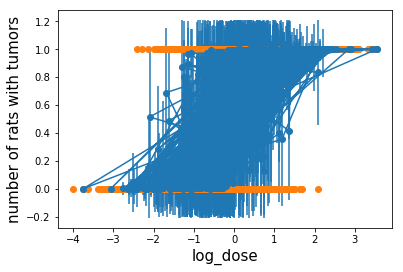

In [61]:
plt.errorbar(x=log_dose_to_predict, y=np.asarray(ppc['obs_deaths']).mean(axis=0), yerr=np.asarray(ppc['obs_deaths']).std(axis=0), linestyle='', marker='o')
plt.plot(log_dose, deaths, 'o')
plt.xlabel('log_dose',size=15)
plt.ylabel('number of rats with tumors',size=15)

In [10]:
# from pymc3 import Model, Normal, HalfNormal
# X1 = np.linspace(-3,7,101) # alpha
# X2 = np.linspace(-10, 30,100) # beta
# k=0;j=0
# pp=np.zeros((101,100))
# for x1 in X1:
#     j=0
#     for x2 in X2:
#         pp[k,j]=calc_posterior(x1,x2)
#         j +=1
#     k +=1

# basic_model = Model()

# with basic_model:

#     # Priors for unknown model parameters
#     alpha = Normal('alpha', mu=0, sd=10)
#     beta = Normal('beta', mu=0, sd=10, shape=2)
#     sigma = HalfNormal('sigma', sd=1)

#     # Expected value of outcome
#     mu = alpha + beta[0]*X1 + beta[1]*X2

#     # Likelihood (sampling distribution) of observations
#     Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [ ]:
# rf = RandomForestRegressor(n_estimators = 100, max_features='sqrt')
# rf.fit(X, y)
# # feature importances
# # the higher, the more important the feature
# d = {'importance': rf.feature_importances_}
# pd.DataFrame(d, index=X.columns).sort('importance')

In [33]:
#Toy Data Random Forest data
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
X_train = scaler.fit(X).transform(X)
y_train = y

In [34]:
clf = RandomForestClassifier(max_depth=100,max_features='sqrt', random_state=0)
clf.fit(X_train, y_train)

print(clf.feature_importances_)

#print(clf.predict([[0, 0, 0, 0]]))
# not such a great result with our naive random forest...
# we take np.abs because scikit learn returns a negative number for mean_absolute_error by default

np.abs(cross_val_score(clf, X_train, y_train, cv=10 ).mean())
#cross_val_score(model, df, y, cv=6)

[ 0.09424372  0.83597175  0.03343739  0.03634714]


0.94484548454845485

In [41]:
#{'beta0': array(1.9854704735996134), 'beta': array(2.9168537609096776), 'alpha': array(0.9053831851570006)}

In [40]:
#logistic Regression
logit = LogisticRegression(fit_intercept=True)

# Fit model. Let X_train = matrix of predictors, y_train = matrix of variable.
# NOTE: Do not include a column for the intercept when fitting the model.
resLogit = logit.fit(X_train, y_train)
print(resLogit.coef_)
np.abs(cross_val_score(resLogit, X_train, y_train, cv=10 ).mean())

[[ 1.9741301   2.90014277]]


0.85720154000153992

In [20]:
print(clf.predict([[-0.71438705,  1.04372761]]))
#X_train[:20]
#np.count_nonzero(y_train == 1)

[1]


In [22]:
clf.predict_proba([[-0.71438705,  1.04372761]])

array([[ 0.1,  0.9]])

In [27]:
print( np.abs(cross_val_score(clf, X_train, y_train, cv=10 ).mean()),
np.abs(cross_val_score(resLogit, X_train, y_train, cv=10 ).mean()) )

0.827098030498 0.857201540002


In [25]:
# Initiate logistic regression object
logit = LogisticRegression(C=1e9,fit_intercept=True)

# Fit model. Let X_train = matrix of predictors, y_train = matrix of variable.
# NOTE: Do not include a column for the intercept when fitting the model.
resLogit = logit.fit(X_train, y_train)
#print(resLogit.intercept_,resLogit.coef_)

# Calculate matrix of predicted class probabilities. 
# Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
predProbs = np.matrix(resLogit.predict_proba(X_train))

# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.column_stack((np.ones(shape = X_train.shape[0]), X_train))
#np.ones(shape = X_train.shape[0])
#X_design =X_train

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.matrix(np.zeros(shape = (X_design.shape[0], X_design.shape[0])))
np.fill_diagonal(V, np.multiply(predProbs[:,0], predProbs[:,1]).A1)

# Covariance matrix
covLogit = np.linalg.inv(X_design.T * V * X_design)
#print("Covariance matrix: ", covLogit)

# Standard errors
print("Standard errors: ", np.sqrt(np.diag(covLogit)) )

# Wald statistic (coefficient / s.e.) ^ 2
logitParams = np.insert(resLogit.coef_, 0, resLogit.intercept_)
print("Coefficients:    ",logitParams)
#print( "Wald statistics: ", (logitParams / np.sqrt(np.diag(covLogit))) ** 2)

Standard errors:  [ 0.03531992  0.04883996  0.06290314]
Coefficients:     [ 0.90538252  1.98547107  2.91685876]


In [55]:
import statsmodels.formula.api as sm
 
model = sm.Logit(y_train, X_design)
 
result =model.fit() #model.fit(method='bfgs')
result.summary()

Optimization terminated successfully.
         Current function value: 0.310366
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Fri, 29 Sep 2017   Pseudo R-squ.:                  0.5410
Time:                        00:11:01   Log-Likelihood:                -3103.7
converged:                       True   LL-Null:                       -6762.0
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9054      0.035     25.634      0.000         0.836     0.975
x1             1.9855      0.049     40.653      0.000         1.890     2.081
x2             2.9169      0.063     46.371      0.000         2.794     3.040
==============================================================================
"""

In [56]:
print("Standard errors: ", np.sqrt(np.diag(covLogit)) )
logitParams = np.insert(resLogit.coef_, 0, resLogit.intercept_)
print([round(float(c+(1.96*v)),3) for c,v in zip(logitParams,np.sqrt(np.diag(covLogit)))])
print([round(float(x),3) for x in logitParams])
print([round(float(c-(1.96*v)),3) for c,v in zip(logitParams,np.sqrt(np.diag(covLogit)))])

Standard errors:  [ 0.03531992  0.04883996  0.06290314]
[0.975, 2.081, 3.04]
[0.905, 1.985, 2.917]
[0.836, 1.89, 2.794]


In [30]:
[round(float(c+1.96*v),3) for c,v in zip(logitParams,np.sqrt(np.diag(covLogit)))]
[round(float(c-1.96*v),3) for c,v in zip(logitParams,np.sqrt(np.diag(covLogit)))]

[0.489, 0.831, 1.335]

In [31]:
for c,v in zip(logitParams,np.sqrt(np.diag(covLogit))):
    print(v)

0.355785946657
0.420717909496
0.559726623114


In [32]:
1.1868-(1.96*0.356)

0.48904000000000014